# Image Detection (TFLite)
Developed by Marcelo Rovai - 19Aug20

Reference: [TensorFlow Lite inference](https://www.tensorflow.org/lite/guide/inference)
- Also see: 
    - [Python quickstart](https://www.tensorflow.org/lite/guide/python)
    - [TensorFlow Lite Python object detection example with Pi Camera](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi)
    - [Object detection](https://www.tensorflow.org/lite/models/object_detection/overview)
    - [How to Set Up Object Detection on Raspberry Pi with TensorFlow Lite](https://peyanski.com/how-to-set-up-object-detection-on-raspberry-pi-with-tensorflow-lite/)

The term inference refers to the process of executing a TensorFlow Lite model on-device in order to make predictions based on input data. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast. The interpreter uses a static graph ordering and a custom (less-dynamic) memory allocator to ensure minimal load, initialization, and execution latency.

## Install just the TensorFlow Lite interpreter

To quickly run TensorFlow Lite models with Python, you can install just the TensorFlow Lite interpreter, instead of all TensorFlow packages.

For example, if you have Raspberry Pi that's running Raspbian Buster (which has Python 3.7), install the Python wheel as follows:

`$ sudo pip3 install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp37-cp37m-linux_armv7l.whl`

### Download models and labels

**Pre-trained quantized COCO SSD MobileNet v1 model**<br>

Input

The model takes an image as input. The expected image is 300x300 pixels, with three channels (red, blue, and green) per pixel. This should be fed to the model as a flattened buffer of 270,000 byte values (300x300x3). Since the model is quantized, each value should be a single byte representing a value between 0 and 255.

Output

Labels based on [Microsoft COCO: Common Objects in Context](https://arxiv.org/pdf/1405.0312.pdf)

What is COCO?<br>
[COCO](https://cocodataset.org/#home) is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:
- Object segmentation
- Recognition in context
- Superpixel stuff segmentation
- 330K images (>200K labeled)
- 1.5 million object instances
- 80 object categories
- 91 stuff categories (includes 1 as "non-category)
- 5 captions per image
- 250,000 people with keypoints

The model outputs four arrays , mapped to the indices 0-4. Arrays 0, 1, and 2 describe 10 detected objects, with one element in each array corresponding to each object. There will always be 10 objects detected.

- Bounding Box ==> (ymin, xmin, ymax, xmax)
- Class ID (0 to 89) ("Stuff categories")
- Score (0 to 1)

Get TF Lite model and labels<br>`
$ cd ./models 
$ curl -O http://storage.googleapis.com/download.tensorflow.org/models/tflite/coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip
$ unzip coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip
$ curl -O  https://dl.google.com/coral/canned_models/coco_labels.txt`

Remove files<br>
`$ rm coco_ssd_mobilenet_v1_1.0_quant_2018_06_29.zip
$ rm labelmap.txt`

It is possible to significantly speed up the inference time, attaching an ML accelerator such as the Coral USB Accelerator—a USB accessory that adds the Edge TPU ML accelerator to any Linux-based system. If a Coral USB Accelerator is used, it is necessary to also get version compiled for Edge TPU (not used in this project) <br>
`$ curl -O  https://dl.google.com/coral/canned_models/mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite`

## Libraries and setup

In [1]:
import io
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tflite_runtime.interpreter import Interpreter

## Main Functions

In [2]:
def load_labels(path):
    """Loads the labels file. Supports files with or without index numbers."""
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        labels = {}

        for row_number, content in enumerate(lines):
            pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
            if len(pair) == 2 and pair[0].strip().isdigit():
                labels[int(pair[0])] = pair[1].strip()
            else:
                labels[row_number] = pair[0].strip()
        return labels


def set_input_tensor(interpreter, image):
    """Sets the input tensor."""
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
    """Returns the output tensor at the given index."""
    output_details = interpreter.get_output_details()[index]
    tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
    return tensor    


def detect_objects(interpreter, image, threshold):
    """Returns a list of detection results, each a dictionary of object info."""
    set_input_tensor(interpreter, image)
    interpreter.invoke()

    # Get all output details
    boxes = get_output_tensor(interpreter, 0)
    classes = get_output_tensor(interpreter, 1)
    scores = get_output_tensor(interpreter, 2)
    count = int(get_output_tensor(interpreter, 3))

    results = []
    for i in range(count):
        if scores[i] >= threshold:
            result = {
              'bounding_box': boxes[i],
              'class_id': classes[i],
              'score': scores[i]
            }
            results.append(result)
    return results

## Load Interpreter (Model / labels)

In [3]:
!ls ./models

coco_labels.txt  detect.tflite


In [11]:
labels = load_labels('./models/coco_labels.txt')
interpreter = Interpreter('./models/detect.tflite')
interpreter.allocate_tensors()

In [13]:
interpreter.get_input_details()

[{'name': 'normalized_input_image_tensor',
  'index': 175,
  'shape': array([  1, 300, 300,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128]),
   'quantized_dimension': 0}}]

In [14]:
interpreter.get_output_details()

[{'name': 'TFLite_Detection_PostProcess',
  'index': 167,
  'shape': array([ 1, 10,  4]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}},
 {'name': 'TFLite_Detection_PostProcess:1',
  'index': 168,
  'shape': array([ 1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}},
 {'name': 'TFLite_Detection_PostProcess:2',
  'index': 169,
  'shape': array([ 1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0}},
 {'name': 'TFLite_Detection_PostProcess:3',
  'index': 170,
  'shape': array([1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_pa

In [4]:
_, height, width, _ = interpreter.get_input_details()[0]['shape']
print("Input images shape: \n- Height: {}\n- Width:  {}".format(height, width))

Input images shape: 
- Height: 300
- Width:  300


In [16]:
print(labels)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 12: 'stop sign', 13: 'parking meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 26: 'backpack', 27: 'umbrella', 30: 'handbag', 31: 'tie', 32: 'suitcase', 33: 'frisbee', 34: 'skis', 35: 'snowboard', 36: 'sports ball', 37: 'kite', 38: 'baseball bat', 39: 'baseball glove', 40: 'skateboard', 41: 'surfboard', 42: 'tennis racket', 43: 'bottle', 45: 'wine glass', 46: 'cup', 47: 'fork', 48: 'knife', 49: 'spoon', 50: 'bowl', 51: 'banana', 52: 'apple', 53: 'sandwich', 54: 'orange', 55: 'broccoli', 56: 'carrot', 57: 'hot dog', 58: 'pizza', 59: 'donut', 60: 'cake', 61: 'chair', 62: 'couch', 63: 'potted plant', 64: 'bed', 66: 'dining table', 69: 'toilet', 71: 'tv', 72: 'laptop', 73: 'mouse', 74: 'remote', 75: 'keyboard', 76: 'cell phone', 77: 'microw

### Make a test on a image

In [6]:
ls ./images

beagles.jpg  car_5.jpg  cat_dog.jpeg    dog_4.jpg         table.jpg
beatch.jpg   cat_1.jpg  cat.png         man_cat_dog.jpeg  tiger.jpg
bulldog.jpg  cat_2.jpg  cats_dogs.jpeg  mixed.jpeg        tina_0.jpeg
car_1.jpg    cat_2.png  doberman.jpg    office.jpeg
car_2.jpg    cat_3.jpg  dog_1.jpg       pi_1.jpeg
car_3.jpg    cat_4.jpg  dog_2.jpg       ship_1.jpg
car_4.jpg    cat_5.jpg  dog_3.jpg       ship_2.jpg


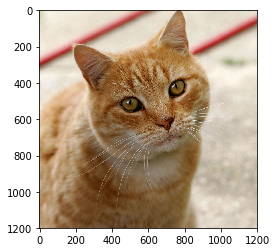

In [41]:
image_path = "./images/cat_2.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [17]:
img.shape

(1199, 1200, 3)

  Image Shape:  (300, 300, 3)


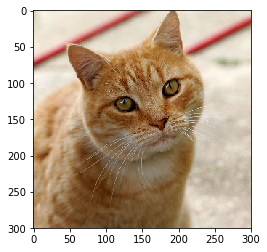

In [25]:
image = cv2.resize(img, (300, 300))
plt.imshow(image);
print("  Image Shape: ", image.shape)

In [26]:
%time results = detect_objects(interpreter, image, 0.4)
results

CPU times: user 199 ms, sys: 0 ns, total: 199 ms
Wall time: 210 ms


[{'bounding_box': array([0.02801108, 0.02012181, 0.9886069 , 0.802299  ], dtype=float32),
  'class_id': 16.0,
  'score': 0.765625}]

In [29]:
ymin, xmin, ymax, xmax = results[0]['bounding_box']
ymin, xmin, ymax, xmax

(0.028011084, 0.020121813, 0.9886069, 0.802299)

In [31]:
type(labels)

dict

In [32]:
labels[16]

'cat'

In [33]:
id = int(results[0]['class_id'])
labels[id]

'cat'

In [34]:
prob = int(round(results[0]['score'], 2)*100)
prob

76

In [35]:
img.shape

(1199, 1200, 3)

In [36]:
HEIGHT, WIDTH, _ = img.shape
ymin, xmin, ymax, xmax = results[0]['bounding_box']
xmin = int(xmin * WIDTH)
xmax = int(xmax * WIDTH)
ymin = int(ymin * HEIGHT)
ymax = int(ymax * HEIGHT)
ymin, xmin, ymax, xmax

(33, 24, 1185, 962)

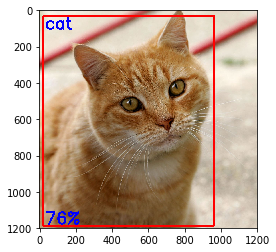

In [43]:
font = cv2.FONT_HERSHEY_SIMPLEX
img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 10, 3 )
img = cv2.putText(img, labels[id], (xmin+10, ymin+70), font, 3, (0, 0, 255), 10)
img = cv2.putText(img, str(prob)+"%", (xmin+10, ymax-10), font, 3, (0, 0, 255), 10)
plt.imshow(img); 

### Creating a function for a single image

In [45]:
def detectObjImg(img_path):

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(img, (width, height), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    results = detect_objects(interpreter, image, 0.4)
    
    id = int(results[0]['class_id'])
    prob = int(round(results[0]['score'], 2)*100)
    
    HEIGHT, WIDTH, _ = img.shape
    ymin, xmin, ymax, xmax = results[0]['bounding_box']
    xmin = int(xmin * WIDTH)
    xmax = int(xmax * WIDTH)
    ymin = int(ymin * HEIGHT)
    ymax = int(ymax * HEIGHT)
    
    scale = HEIGHT/600
    ln = int(6*scale)
    hf = int(ln/3)

    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), ln, 3 )
    img = cv2.putText(img, labels[id], (xmin+ln, ymin+7*ln), font, hf, (0, 0, 255), ln)
    img = cv2.putText(img, str(prob)+"%", (xmin+ln, ymax-ln), font, hf, (0, 0, 255), ln)
    plt.figure(figsize=(15,8))
    plt.imshow(img)
    plt.axis('off'); 

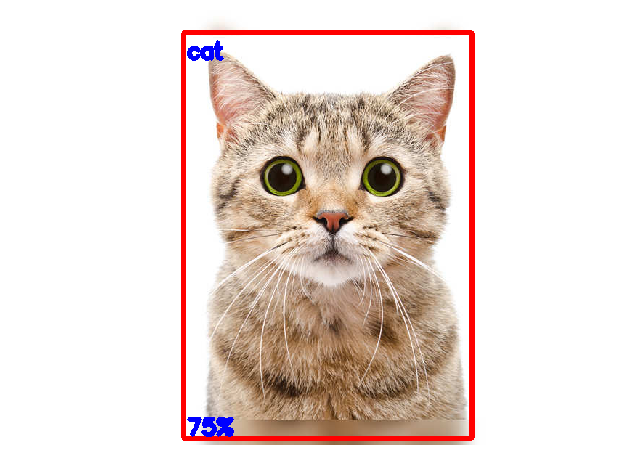

In [47]:
image_path = "./images/cat_1.jpg"
detectObjImg(image_path)

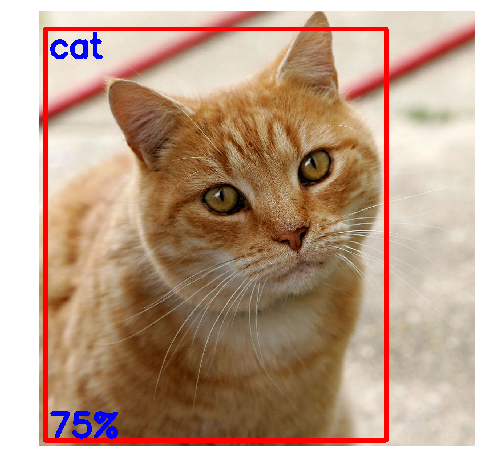

In [34]:
image_path = "./images/cat_2.jpg"
detectObjImg(image_path)

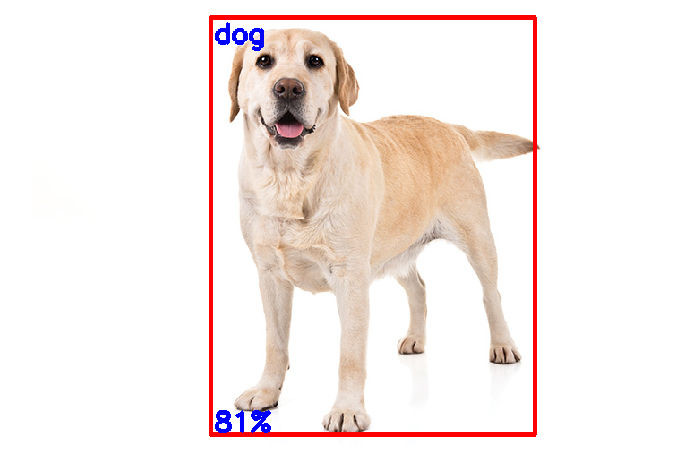

In [48]:
image_path = "./images/dog_1.jpg"
detectObjImg(image_path)

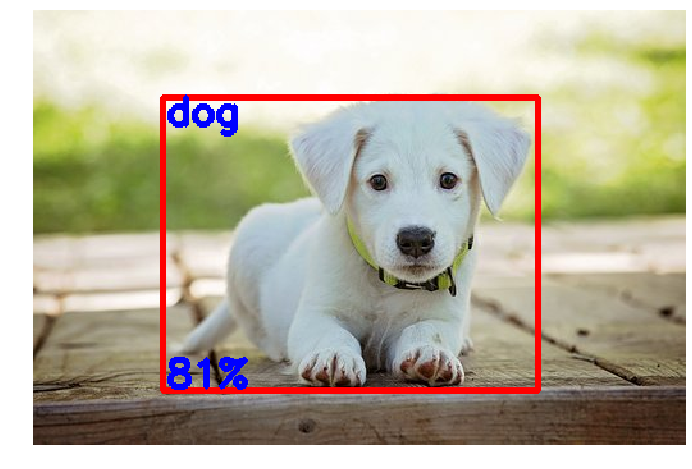

In [49]:
image_path = "./images/dog_2.jpg"
detectObjImg(image_path)

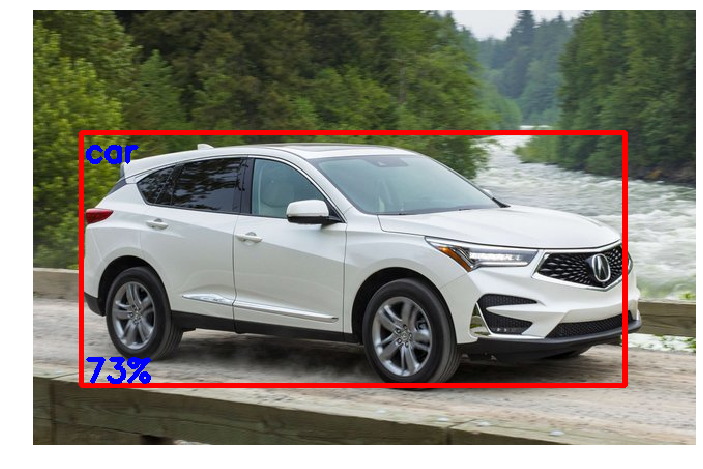

In [40]:
image_path = "./images/car_2.jpg"
detectObjImg(image_path)

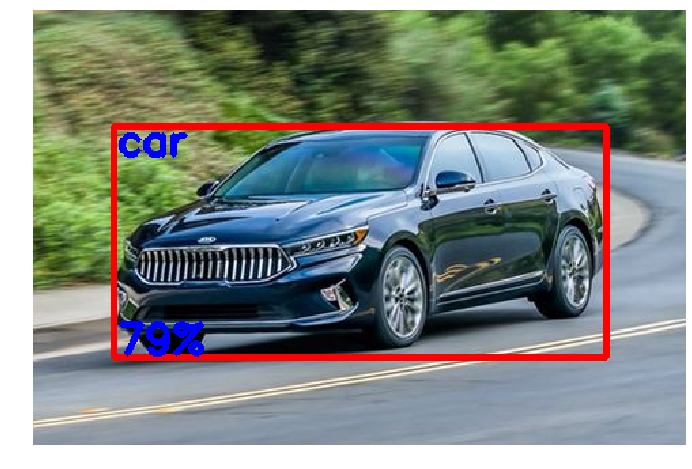

In [43]:
image_path = "./images/car_3.jpg"
detectObjImg(image_path)

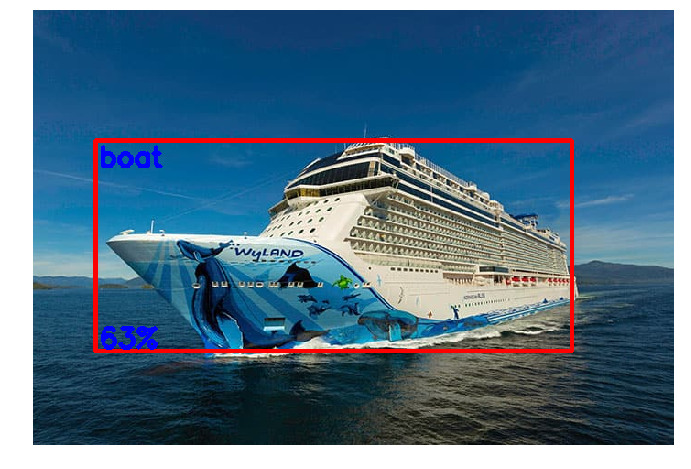

In [41]:
image_path = "./images/ship_1.jpg"
detectObjImg(image_path)

CPU times: user 389 ms, sys: 20.1 ms, total: 409 ms
Wall time: 432 ms


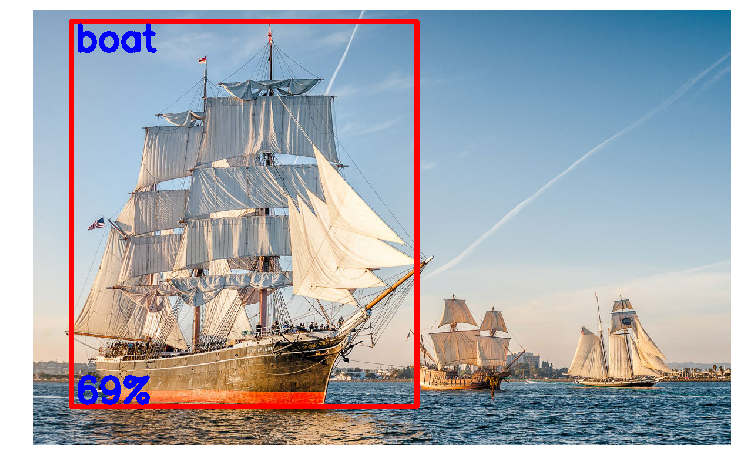

In [45]:
%%time 
image_path = "./images/ship_2.jpg"
detectObjImg(image_path)

### Expanding detection for multiple objects

In [50]:
FONT = cv2.FONT_HERSHEY_SIMPLEX
COLORS = np.random.uniform(0, 255, size=(90, 3))

In [72]:
def detectObjImg_2(image_path, threshold=0.51):

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(img, (width, height), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    results = detect_objects(interpreter, image, threshold)
    
    return img, results

In [52]:
def detect_mult_object_picture(img, results):
    
    HEIGHT, WIDTH, _ = img.shape
    aspect = WIDTH/HEIGHT
    WIDTH = 640
    HEIGHT = int(640/aspect)
    dim = (WIDTH, HEIGHT)
    
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
     
    for i in range(len(results)):
        id = int(results[i]['class_id'])
        prob = int(round(results[i]['score'], 2)*100)
        
        ymin, xmin, ymax, xmax = results[i]['bounding_box']
        xmin = int(xmin * WIDTH)
        xmax = int(xmax * WIDTH)
        ymin = int(ymin * HEIGHT)
        ymax = int(ymax * HEIGHT)
        
        text = "{}: {}%".format(labels[id], prob)
        
        if ymin > 10: ytxt = ymin-10
        else: ytxt = ymin+15
       
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), COLORS[id], thickness=2)
        img = cv2.putText(img, text, (xmin+3, ytxt), FONT, 0.5, COLORS[id], 2)

    return img

In [53]:
labels = load_labels('./models/coco_labels.txt')
interpreter = Interpreter('./models/detect.tflite')
interpreter.allocate_tensors()
_, height, width, _ = interpreter.get_input_details()[0]['shape']

In [54]:
!ls ./images

beagles.jpg  car_5.jpg	cat_dog.jpeg	dog_4.jpg	  table.jpg
beatch.jpg   cat_1.jpg	cat.png		man_cat_dog.jpeg  tiger.jpg
bulldog.jpg  cat_2.jpg	cats_dogs.jpeg	mixed.jpeg	  tina_0.jpeg
car_1.jpg    cat_2.png	doberman.jpg	office.jpeg
car_2.jpg    cat_3.jpg	dog_1.jpg	pi_1.jpeg
car_3.jpg    cat_4.jpg	dog_2.jpg	ship_1.jpg
car_4.jpg    cat_5.jpg	dog_3.jpg	ship_2.jpg


In [55]:
%%time 
img, results = detectObjImg_2("./images/beatch.jpg")

CPU times: user 288 ms, sys: 52.4 ms, total: 340 ms
Wall time: 337 ms


In [56]:
len(results)

10

In [57]:
results

[{'bounding_box': array([0.5735694 , 0.05015806, 0.6181872 , 0.06799744], dtype=float32),
  'class_id': 0.0,
  'score': 0.75},
 {'bounding_box': array([0.09147759, 0.4482636 , 0.16664483, 0.49655044], dtype=float32),
  'class_id': 37.0,
  'score': 0.66796875},
 {'bounding_box': array([0.5811172 , 0.01859174, 0.61981887, 0.03456265], dtype=float32),
  'class_id': 0.0,
  'score': 0.65625},
 {'bounding_box': array([0.26222512, 0.20842475, 0.3170204 , 0.22626412], dtype=float32),
  'class_id': 37.0,
  'score': 0.64453125},
 {'bounding_box': array([0.43465364, 0.7949864 , 0.4619884 , 0.81282586], dtype=float32),
  'class_id': 37.0,
  'score': 0.59765625},
 {'bounding_box': array([0.3818236 , 0.42617854, 0.40239   , 0.442925  ], dtype=float32),
  'class_id': 37.0,
  'score': 0.57421875},
 {'bounding_box': array([0.5938907 , 0.09761055, 0.62693423, 0.1130845 ], dtype=float32),
  'class_id': 0.0,
  'score': 0.5625},
 {'bounding_box': array([0.7796342 , 0.1651848 , 0.9351538 , 0.20450297], dtyp

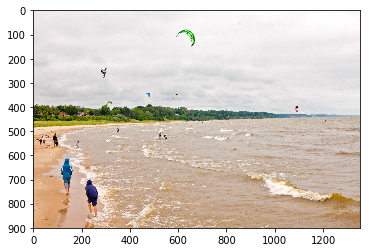

In [58]:
plt.imshow(img);

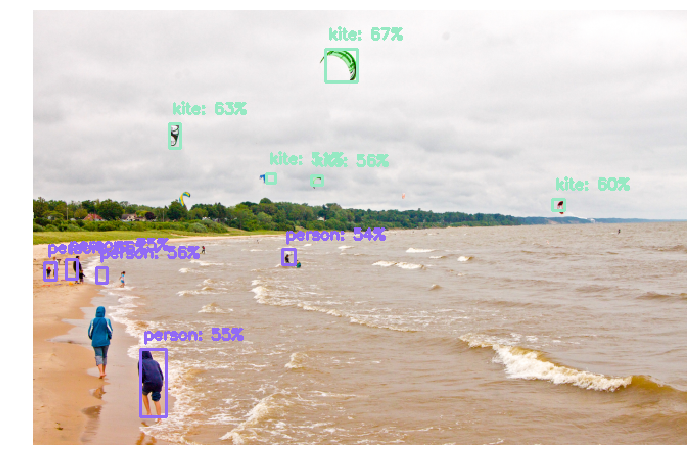

In [59]:
img = detect_mult_object_picture(img, results)
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off'); 

CPU times: user 235 ms, sys: 16.6 ms, total: 252 ms
Wall time: 254 ms


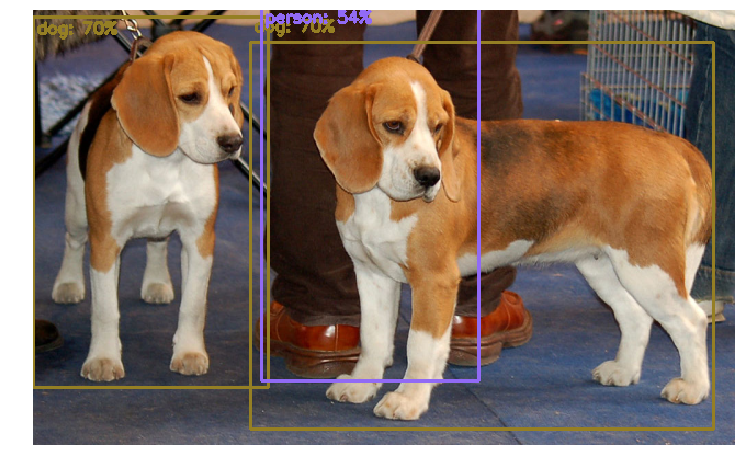

In [60]:
%time img, results = detectObjImg_2("./images/beagles.jpg")
img = detect_mult_object_picture(img, results)
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off'); 

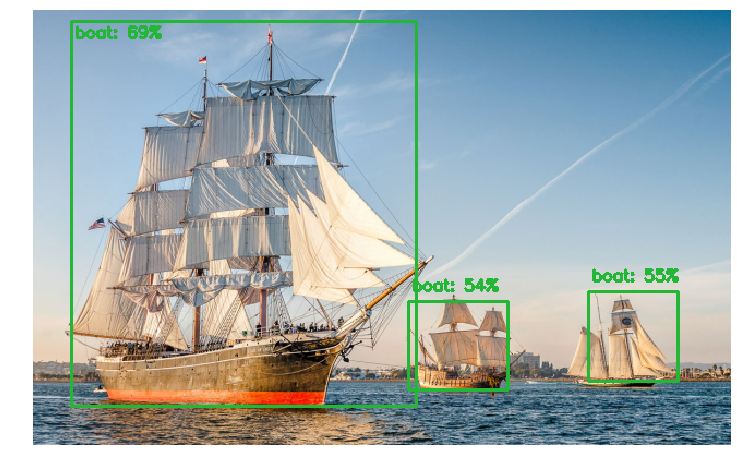

In [62]:
img, results = detectObjImg_2("./images/ship_2.jpg")
img = detect_mult_object_picture(img, results)
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off'); 

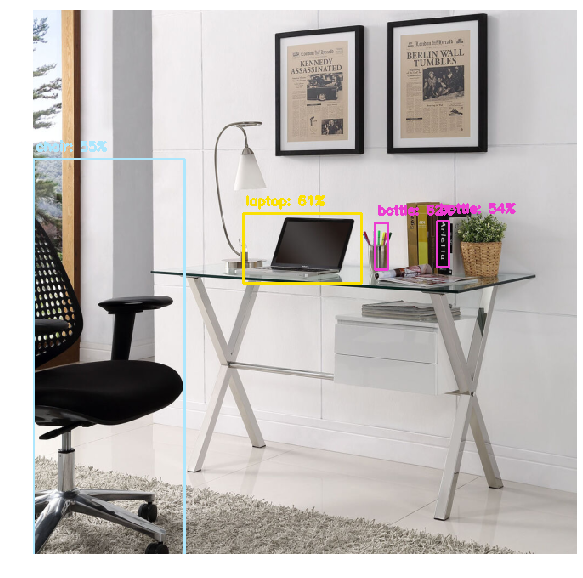

In [63]:
img, results = detectObjImg_2("./images/office.jpeg")
img = detect_mult_object_picture(img, results)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off'); 

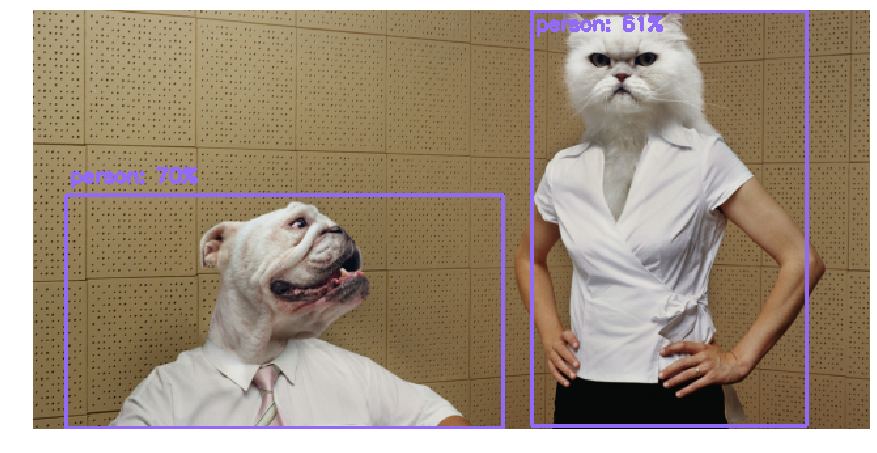

In [64]:
img, results = detectObjImg_2("./images/mixed.jpeg")
img = detect_mult_object_picture(img, results)
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off'); 

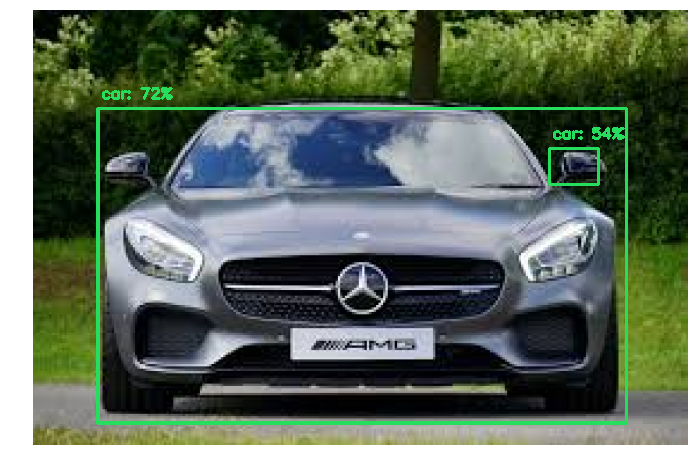

In [65]:
img, results = detectObjImg_2("./images/car_5.jpg")
img = detect_mult_object_picture(img, results)
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off'); 

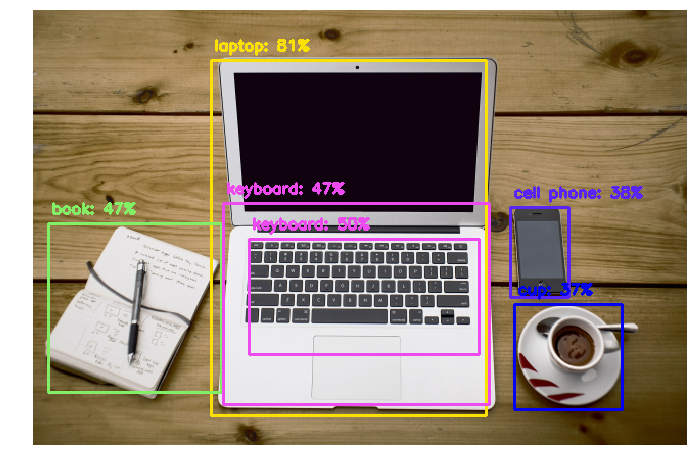

In [79]:
img, results = detectObjImg_2("./images/home-office.jpg", 0.36)
img = detect_mult_object_picture(img, results)
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off'); 

## Using Camera

### Initial Setup

In [58]:
labels = load_labels('./models/coco_labels.txt')
interpreter = Interpreter('./models/detect.tflite')
interpreter.allocate_tensors()
_, height, width, _ = interpreter.get_input_details()[0]['shape']

In [80]:
WIDTH = 640
HEIGHT = 480

In [87]:
cap = cv2.VideoCapture(0)
cap.set(3, WIDTH)
cap.set(4, HEIGHT)

True

In [88]:
while True:
    
    timer = cv2.getTickCount()
    success, img = cap.read()
    img = cv2.flip(img,0)
    img = cv2.flip(img,1)
 
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    cv2.putText(img, "FPS: "+str(int(fps)), (10, 470), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
    
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
    start_time = time.time()
    results = detect_objects(interpreter, image, 0.55)
    elapsed_ms = (time.time() - start_time) * 1000
    
    img = detect_mult_object_picture(img, results)
    cv2.imshow("Image Recognition ==> Press [q] to Exit", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

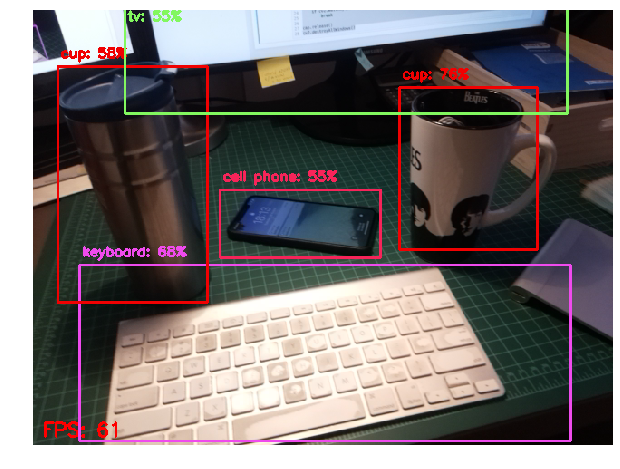

In [86]:
plt.figure(figsize=(15,8))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off'); 